# System Identification in Frequency Domain

In [1]:
import os
import sys
import pywt
import itertools
from itertools import zip_longest
import numpy as np
from numpy.linalg import norm
import math
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.stats import ranksums
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.api import VAR
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter

from scipy.io import loadmat
import seaborn as sns
from math import floor
import tkinter as tk
import decimal
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import concurrent.futures # for parallel processing
import glob
import pickle

# Loading The Dataset (Trial by Trial)

In [2]:
# Get the participant data from Dataset directory
global t0, fs, dt, num_eeg_ch, num_emg_ch, num_force_ch, num_ch, num_conds
t0 = 0
fs = 1200
dt = 1.0/fs
num_eeg_ch = 14
num_emg_ch = 4
num_force_ch = 3
num_ch = num_eeg_ch + num_emg_ch + num_force_ch
num_conds = 18

# Get a list of files to process
data_files = list(map(loadmat, glob.glob("Dataset/*.mat")))
num_participants = len(data_files)

columns=['EEG-1','EEG-2','EEG-3','EEG-4','EEG-5',
         'EEG-6','EEG-7','EEG-8','EEG-9','EEG-10',
         'EEG-11','EEG-12','EEG-13','EEG-14','EMG-1',
         'EMG-2','EMG-3','EMG-4','Force-x', 
         'Force-y','Force-z']

glob.glob("Dataset/*.mat")

['Dataset/YK1200Hz.mat',
 'Dataset/BT1200Hz.mat',
 'Dataset/YA1200Hz.mat',
 'Dataset/YZ1200Hz.mat',
 'Dataset/WC1200Hz.mat',
 'Dataset/P11200Hz.mat',
 'Dataset/JT1200Hz.mat',
 'Dataset/HCH1200Hz.mat',
 'Dataset/ED1200Hz.mat',
 'Dataset/CC1200Hz.mat',
 'Dataset/KH1200Hz.mat']

In [3]:
def extract_data(file):
    data_splitBy_trials = [] # list of data frames, each df corresponding to a trial

    for cond in tqdm_notebook(range(num_conds), ascii=True):
        num_trials = file['EEGSeg_Ch'][0,0][0,cond].shape[0]
        # if a trial has long enough samples
        if file['EEGSeg_Ch'][0,0][0,cond].shape[1] >= 400:
            for trial in range(num_trials): 
                data = pd.DataFrame(columns=columns)
                for ch in range(num_eeg_ch):
                    data.iloc[:,ch] = file['EEGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_emg_ch):
                    data.iloc[:,ch+num_eeg_ch] = file['EMGSeg_Ch'][0,ch][0,cond][trial,:]
                for ch in range(num_force_ch):
                    data.iloc[:,ch+num_eeg_ch+num_emg_ch] = file['ForceSeg_Ch'][0,ch][0,cond][trial,:]

                # mean subtraction in each trial from the eeg and emg columns for removing dc drift
                data.iloc[:,:18] -= data.iloc[:,:18].mean()
                # convert volts to microvolts for EEG and EMG channels
                data.iloc[:,:18] *= 1e6
                # convert volts to milivolts for force channels
                data.iloc[:,18:] *= 1e3  
                data_splitBy_trials.append(data)
                
    train_data, test_data = train_test_split(data_splitBy_trials)
    return train_data, test_data


def train_test_split(data, train_ratio=0.5):
    '''
    with train ratio=x, we use x ratio of the trials from a participant for training 
    and other trials for testing
    '''
    num_train = int(train_ratio*len(data))
    train_data, test_data = data[:num_train], data[num_train:]
    return train_data, test_data


train_data = [] # train data is a list (all participants each trial) of dataframes
test_data = [] # test data is a list (each participant) of list (each trial) of dataframes 

print('Reading and processing in parallel.')

# Create a pool of processes. By default, one is created for each CPU in your machine.
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Process the list of files, but split the work across the process pool to use all CPUs.
    # executor.map() function takes in the helper function to call and the list of data to process with it.
    # executor.map() function returns results in  the same order as the list of data given to the process.
    for train, test in tqdm_notebook(executor.map(extract_data, data_files), total=len(data_files)):
        train_data.extend(train)
        test_data.append(test)
        
total_trials = len(train_data)
for test in test_data:
    total_trials += len(test)
print('Total number of trials of all the conditions in the file: %i' %total_trials) 
train_data[0].head(10) # first 10 samples of the first trial

Reading and processing in parallel.










Total number of trials of all the conditions in the file: 17648


,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,...,EEG-12,EEG-13,EEG-14,EMG-1,EMG-2,EMG-3,EMG-4,Force-x,Force-y,Force-z
0,5.345910,19.418285,-3.070039,5.136301,5.884714,5.158745,8.752532,7.102954,11.347657,7.036862,...,7.399027,5.883024,10.095295,506.688060,-213.138035,-174.356741,12.045341,-467.459887,-469.139874,-207.874909
1,4.435385,19.020762,-3.628572,4.296643,5.082999,4.745096,7.820139,6.427465,10.836605,6.266054,...,6.594318,5.472668,9.063170,328.242929,-215.313604,-196.455163,-23.687644,-467.535824,-469.067961,-207.887575
2,3.847221,18.674868,-3.831801,3.865269,4.650446,4.594528,7.242427,6.093130,10.538305,5.809399,...,6.161721,5.323854,8.514384,151.653109,-183.931759,-155.938905,-55.665536,-467.533022,-468.959302,-207.152665
3,3.603774,18.380687,-3.674401,3.842606,4.607264,4.713468,7.041713,6.109928,10.458913,5.688816,...,6.114221,5.429132,8.467317,-181.735576,-189.892223,-159.127754,-106.240077,-467.513472,-468.900919,-202.871338
4,3.689995,18.117242,-3.188843,4.186353,4.931073,5.075832,7.197616,6.446833,10.575788,5.887191,...,6.422288,5.751820,8.885279,-410.738775,-153.026750,-96.021336,-70.358081,-467.391372,-468.960315,-191.237614
5,4.057661,17.847283,-2.439563,4.818495,5.561627,5.627972,7.651973,7.037149,10.842457,6.352709,...,7.019090,6.232408,9.682839,-405.119465,-161.281994,-117.151183,-74.679418,-467.294574,-469.046891,-168.396696
6,4.633439,17.524541,-1.513476,5.636060,6.409659,6.296711,8.317776,7.787745,11.196373,7.006967,...,7.809756,6.797469,10.737298,-244.489604,-119.737556,-74.355048,-55.069489,-467.237562,-469.149798,-140.250966
7,5.329640,17.102525,-0.508091,6.524410,7.368761,6.999675,9.091279,8.591342,11.568894,7.756288,...,8.683958,7.370334,11.904372,31.585140,-129.304102,-78.825396,-48.334165,-467.317641,-469.164819,-119.472846
8,6.055974,16.543206,0.481113,7.371228,8.328650,7.656336,9.865389,9.340053,11.895449,8.504188,...,9.529569,7.881696,13.035649,356.687150,-131.300857,-92.996400,-20.439191,-467.455775,-469.164103,-112.316601
9,6.731252,15.824828,1.372474,8.079716,9.188384,8.198436,10.542783,9.938579,12.124887,9.163631,...,10.246135,8.278823,13.995777,276.773154,-162.712505,-84.443134,-5.240006,-467.580467,-469.057769,-119.524479


In [4]:
trial_id = 40 # choose one trial
num_samples = train_data[trial_id].shape[0]
time = (np.arange(0, num_samples) * dt + t0) * 1e3
# pick one channel from eeg, emg and force
eeg_signal_1 = train_data[trial_id].iloc[:,0] # trial id, eeg_ch1
emg_signal_1 = train_data[trial_id].iloc[:,14] # trial id, emg_ch1
force_signal_3 = train_data[trial_id].iloc[:,20] # trial id, force_ch3

# Visualization of The Dataset

In [ ]:
def get_ave_values(xvalues, yvalues, n):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(average_over))
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc='upper right')

fig, axes = plt.subplots(3, figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
plot_signal_plus_average(axes[0], time, eeg_signal_1, average_over=3)

axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[0].set_title('EEG Channel-1', fontsize=16)
plot_signal_plus_average(axes[1], time, emg_signal_1, average_over=3)

axes[1].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_title('EMG Channel-1', fontsize=16)
plot_signal_plus_average(axes[2], time, force_signal_3, average_over=3)

axes[2].set_ylabel('Amplitude (mV)', fontsize=16)
axes[2].set_xlabel('Time (sec)', fontsize=16)
axes[2].set_title('Force Channel-3', fontsize=16)

plt.show()

# Fourier Transform of The Data

In [ ]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(axes, time, signal, N, fs=fs, dt=dt,
                        plot_direction='horizontal', yticks=None, ylim=None):
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2

    if plot_direction == 'horizontal':
        axes[0].plot(f_values, fft_values, 'r-', label='Fourier Transform')
        axes[1].plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        axes[0].plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        axes[1].plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        axes[0].set_yticks(np.log2(yticks))
        axes[0].set_yticklabels(yticks)
        axes[0].invert_yaxis()
        axes[0].set_ylim(ylim[0], -1)
    axes[0].legend()
    axes[1].legend()

fig, axes = plt.subplots(6, figsize=(12,30))
fig.subplots_adjust(hspace=0.3)
axes[0].set_title('Fourier Transform - EEG Channel 1', fontsize=16)
axes[1].set_title('FFT Power Spectrum - EEG Channel 1', fontsize=16)
axes[0].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[1].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[0], axes[1]], time, eeg_signal_1, len(eeg_signal_1))

axes[2].set_title('Fourier Transform - EMG Channel 1', fontsize=16)
axes[3].set_title('FFT Power Spectrum - EMG Channel 1', fontsize=16)
axes[2].set_ylabel('Amplitude (\u03bcV)', fontsize=16)
axes[3].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[2], axes[3]], time, emg_signal_1, len(emg_signal_1))

axes[4].set_title('Fourier Transform - Force Channel 3', fontsize=16)
axes[5].set_title('FFT Power Spectrum - Force Channel 3', fontsize=16)
axes[4].set_ylabel('Amplitude (mV)', fontsize=16)
axes[5].set_ylabel('Amplitude', fontsize=16)
plot_fft_plus_power([axes[4], axes[5]], time, force_signal_3, len(force_signal_3))
axes[5].set_xlabel('Frequency [Hz]', fontsize=16)

plt.show()

# Estimation of The Power Spectral Density Using Welch’s Method

In [ ]:
# Welch’s method computes an estimate of the power spectral density by dividing the data
# into overlapping segments, computing a modified periodogram for each segment 
# and averaging the periodograms.

# For the default ‘hanning’ window an overlap of 50% is a reasonable trade off 
# between accurately estimating the signal power, while not over counting any of the data. 
# Narrower windows may require a larger overlap.
for counter, x in enumerate([eeg_signal_1, emg_signal_1, force_signal_3]):
    f, Pxx_spec = welch(x, fs, 'hanning', len(x), scaling='spectrum')
    plt.figure(figsize=(12,6))    
    plt.semilogy(f, np.sqrt(Pxx_spec))
    plt.xlabel('Frequency [Hz]')
    if counter == 0:
        plt.ylabel('EEG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    elif counter == 1:
        plt.ylabel('EMG Channel 1 - Linear spectrum [\u03bcV RMS]', fontsize=16)
    else:
        plt.ylabel('Force Channel z - Linear spectrum [mV RMS]', fontsize=16)
    plt.show()
    
# The peak height in the power spectrum is an estimate of the RMS amplitude.

# Vector Auto-Regression Based in Time Domain

#### Practice

In [ ]:
trial = 15
train_data[trial].head(3)

In [ ]:
participant = 2
trial = 15
test_data[participant][trial].head(3)

#### Concatenate dataframes of all trials to a single dataframe

In [4]:
eeg_ind = list(range(0,14,1))
emg_ind = list(range(14,18,1))
force_ind = list(range(18,21,1))
train_data_df = pd.concat(train_data)

### Model Lag Order Selection (Skip to the next section to use pickled data)

In [ ]:
# saves bic scores for all model orders:
def save_bic(dataframe, filename, use_saved=True):
    if use_saved==True: return
    lag_bic_scores = np.zeros((1,20))
    for P in tqdm_notebook(range(20), ascii=True):
        model = VAR(dataframe)
        results = model.fit(P+1)
        bic_score = results.bic
        lag_bic_scores[0, P] = bic_score
        np.save(filename, lag_bic_scores)

'''
# Only EEG (first 28 columns)   
filename = 'VARResults/onlyEEG_lagOrder.npy'
save_bic(train_data_df.iloc[:,eeg_ind], filename)
print("Lag order selection completed for EEG only.")

# Only EMG (28-35 columns)
filename = 'VARResults/onlyEMG_lagOrder.npy'
save_bic(train_data_df.iloc[:,emg_ind], filename)
print("Lag order selection completed for EMG only.")
 
# Only Force (35-41 columns)
filename = 'VARResults/onlyForce_lagOrder.npy'
save_bic(train_data_df.iloc[:,force_ind], filename)
print("Lag order selection completed for Force only.")

# EEG & EMG
filename = 'VARResults/EEG_EMG_lagOrder.npy'
save_bic(train_data_df.iloc[:,eeg_ind+emg_ind], filename)
print("Lag order selection completed for EEG and EMG.")

# EEG & Force
filename = 'VARResults/EEG_Force_lagOrder.npy'
save_bic(train_data_df.iloc[:,eeg_ind+force_ind], filename)
print("Lag order selection completed for EEG and Force.")

# EMG & Force
filename = 'VARResults/EMG_Force_lagOrder.npy'
save_bic(train_data_df.iloc[:,emg_ind+force_ind], filename)
print("Lag order selection completed for EMG and Force.")

# all
filename = 'VARResults/all_lagOrder.npy'
save_bic(train_data_df.iloc[:,eeg_ind+emg_ind+force_ind], filename)
print("Lag order selection completed for all.")
'''

### Model Lag Order Results (using pickled data)

In [ ]:
all = np.load('VARResults/all_lagOrder.npy')
only_eeg = np.load('VARResults/onlyEEG_lagOrder.npy')
only_emg = np.load('VARResults/onlyEMG_lagOrder.npy')
only_force = np.load('VARResults/onlyForce_lagOrder.npy')
eeg_emg = np.load('VARResults/EEG_EMG_lagOrder.npy')
eeg_force = np.load('VARResults/EEG_Force_lagOrder.npy')
emg_force = np.load('VARResults/EMG_Force_lagOrder.npy')

BIC = pd.DataFrame({'all': all[0,:],
                    'only_eeg': only_eeg[0,:],
                    'only_emg': only_emg[0,:],
                    'only_force': only_force[0,:],
                    'eeg_emg': eeg_emg[0,:],
                    'eeg_force': eeg_force[0,:],
                    'emg_force': emg_force[0,:]})
model_orders = 1 + np.arange(20)

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.6)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(10,12), sharex=False)
sns.despine(left=True)

sns.pointplot(x=model_orders, y=BIC['all'], color='r', ax=axes[0,0], scale=0.4).set_title('EEG, EMG and Force')
sns.pointplot(x=model_orders, y=BIC['eeg_force'], color='b', ax=axes[0,1], scale=0.4).set_title('EEG and Force')
sns.pointplot(x=model_orders, y=BIC['eeg_emg'], color='m', ax=axes[1,0], scale=0.4).set_title('EEG and EMG')
sns.pointplot(x=model_orders, y=BIC['emg_force'], color='g', ax=axes[1,1], scale=0.4).set_title('EMG and Force')
sns.pointplot(x=model_orders, y=BIC['only_eeg'], color='g', ax=axes[2,0], scale=0.4).set_title('Only EEG')
sns.pointplot(x=model_orders, y=BIC['only_force'], color='r', ax=axes[2,1], scale=0.4).set_title('Only Force')

for ax in axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# The rest is for some cosmetics of the plots...
# reduce the density of x-axis
for ax in axes.flatten():
    for ind, label in enumerate(ax.get_xticklabels()):
        if (ind+1) % 5 == 0: #every 5th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

# draw vertical lines:
for i in range(4,24,5):
    axes.flatten()[0].vlines(x=i, ymin=BIC['all'].min()-1, ymax=BIC['all'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[1].vlines(x=i, ymin=BIC['eeg_force'].min()-1, ymax=BIC['eeg_force'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[2].vlines(x=i, ymin=BIC['eeg_emg'].min()-0.6, ymax=BIC['eeg_emg'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[3].vlines(x=i, ymin=BIC['emg_force'].min()-0.1, ymax=BIC['emg_force'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[4].vlines(x=i, ymin=BIC['only_eeg'].min()-1.2, ymax=BIC['only_eeg'].max(), color='black', 
                             alpha=1, linewidth=1, linestyles='dotted')
    axes.flatten()[5].vlines(x=i, ymin=BIC['only_force'].min()-0.1, ymax=BIC['only_force'].max(), 
                             color='black', alpha=1, linewidth=1, linestyles='dotted')

# draw horizontal lines:
for i in range(int(BIC['all'].min()), int(BIC['all'].max()+1), 2):
    axes.flatten()[0].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in range(int(BIC['eeg_force'].min()), int(BIC['eeg_force'].max()+1)):
    axes.flatten()[1].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in range(int(BIC['eeg_emg'].min()), int(BIC['eeg_emg'].max()+1)):
    axes.flatten()[2].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.arange(BIC['emg_force'].min(), BIC['emg_force'].max(), 0.5):
    axes.flatten()[3].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in range(int(BIC['only_eeg'].min()), int(BIC['only_eeg'].max()+1)):
    axes.flatten()[4].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')
for i in np.arange(BIC['only_force'].min(), BIC['only_force'].max(), 0.5):
    axes.flatten()[5].hlines(y=i, xmin=0, xmax=19, color='black', alpha=1, linewidth=1, linestyles='dotted')

# display and save
f.text(0.5, 0.0, 'Model Order (P)', ha='center')
f.text(0.01, 0.5, 'BIC Score', va='center', rotation='vertical')
plt.tight_layout()
plt.savefig("VARResults/lagOrders.pdf", bbox_inches="tight")

### Model Training and Multi-Step Ahead Prediction

In [5]:
def show_entry_fields():
    global nPreds, nAhead
    nPreds, nAhead = int(e1.get()), int(e2.get())
    print("nPreds: %s\nnAhead: %s" % (nPreds, nAhead))
    root.destroy()

root = tk.Tk()

window_height = 80
window_width = 350

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

root.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))
root.title('Prediction Parameters')

# total number of samples to be predicted one-by-one
tk.Label(root, text="num_predictions (max. 200)").grid(row=0)
# number of samples to be predicted at results.forecast case
tk.Label(root, text="num_ahead").grid(row=1)

e1 = tk.Entry(root)
e2 = tk.Entry(root)

e1.grid(row=0, column=1)
e2.grid(row=1, column=1)

tk.Button(root, text='Submit', command=show_entry_fields).grid(row=3, column=1, sticky=tk.W, pady=4)
tk.mainloop()

P = 8 # optimal lag order based on BIC plots
print("Lag Order: 8")

nPreds: 200
nAhead: 1
Lag Order: 8


# Train VAR Models for Each Modality (Skip to next section to use pretrained models)

In [7]:
# Use these figures by default:
# nPreds: number of samples to be predicted one-by-one
# nAhead = 1 number of samples to be predicted at results.forecast case
cols = ['EEG-1','EEG-2','EEG-3','EEG-4',
        'EEG-5','EEG-6','EEG-7','EEG-8',
        'EEG-9','EEG-10','EEG-11','EEG-12',
        'EEG-13','EEG-14','EMG-1','EMG-2',
        'EMG-3','EMG-4','Force-x','Force-y', 'Force-z']

def fit_model(train, test, inds, lag_order=P, nPreds=nPreds, nAhead=nAhead):
    '''
    cols for choosing the wavelet coefficients from eeg, emg and force (modality selection)
    lag order -> how many samples to look back at the past for VAR model training (P=8 -> 7ms)
    nPreds is the total number of predictions to be carried out (200 samples)
    nAhead is number of predictions at a time (1 sample at a time)
    '''
    assert nAhead <= nPreds, ("number of samples to be predicted at each prediction must be"
                              "less than total number of samples to be predicted")
    model = VAR(train).fit(lag_order)  
    forecasted_trials = []
    
    for i, participant in enumerate(tqdm_notebook(test, ascii=True)):
        participant_forecast = []
        for trial in participant:   # for each trial in a wavelet resolution level
            forecasts_trial = []
            # sliding window over last P observed samples to predict next nAhead samples
            for j in range(math.floor(nPreds/nAhead)):
                forecasts_trial.extend(model.forecast(trial.iloc[j*nAhead:j*nAhead+lag_order,
                                                                 inds].values, nAhead))
            # convert the list to a pd.DataFrame
            forecasts_trial = pd.DataFrame(forecasts_trial, columns=[cols[x] for x in inds])                
            participant_forecast.append(forecasts_trial)       
        
        forecasted_trials.append(participant_forecast)
    
    return forecasted_trials

### Save predictions (Skip to the next  section to use pickled predictions)

In [8]:
# Only EEG   
inds = eeg_ind
forecasted_eeg = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_eeg_temporal.dat', "wb") as f:
    pickle.dump(forecasted_eeg, f)

    
# Only EMG 
inds = emg_ind
forecasted_emg = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_emg_temporal.dat', "wb") as f:
    pickle.dump(forecasted_emg, f)


# Only Force 
inds = force_ind
forecasted_force = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_force_temporal.dat', "wb") as f:
    pickle.dump(forecasted_force, f)


# EEG & EMG
inds = eeg_ind + emg_ind
forecasted_eegemg = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_eegemg_temporal.dat', "wb") as f:
    pickle.dump(forecasted_eegemg, f)


# EEG & Force
inds = eeg_ind + force_ind
forecasted_eegforce = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_eegforce_temporal.dat', "wb") as f:
    pickle.dump(forecasted_eegforce, f)


# EMG & Force
inds = emg_ind + force_ind
forecasted_emgforce = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_emgforce_temporal.dat', "wb") as f:
    pickle.dump(forecasted_emgforce, f)


# all
inds = eeg_ind + emg_ind + force_ind
forecasted_all = fit_model(train_data_df.iloc[:,inds], test_data, inds)
with open('VARResults/forecasted_all_temporal.dat', "wb") as f:
    pickle.dump(forecasted_all, f)

### Use Pre-Trained VAR models and pickled predictions 

In [6]:
with open('VARResults/forecasted_all_temporal.dat', "rb") as f:
    forecasted_all = pickle.load(f)
    
with open('VARResults/forecasted_eeg_temporal.dat', "rb") as f:
    forecasted_eeg = pickle.load(f)
    
with open('VARResults/forecasted_emg_temporal.dat', "rb") as f:
    forecasted_emg = pickle.load(f)
    
with open('VARResults/forecasted_force_temporal.dat', "rb") as f:
    forecasted_force = pickle.load(f)
    
with open('VARResults/forecasted_eegforce_temporal.dat', "rb") as f:
    forecasted_eegforce = pickle.load(f)
    
with open('VARResults/forecasted_eegemg_temporal.dat', "rb") as f:
    forecasted_eegemg = pickle.load(f)
    
with open('VARResults/forecasted_emgforce_temporal.dat', "rb") as f:
    forecasted_emgforce = pickle.load(f)

participant = 0
trial_id = 0
forecasted_eeg[participant][trial_id].head(5)

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-6,EEG-7,EEG-8,EEG-9,EEG-10,EEG-11,EEG-12,EEG-13,EEG-14
0,-70.327989,-70.409881,-73.267011,-69.597977,-69.055989,-67.406959,-70.467785,-76.321418,-68.112776,-69.381272,-61.792212,-73.500035,-72.200402,-83.730845
1,-71.019992,-71.012183,-74.282409,-71.525122,-70.322586,-68.433426,-71.884215,-77.408547,-68.580566,-70.095511,-62.666601,-75.077276,-72.453964,-85.163136
2,-71.762788,-71.656636,-75.411254,-73.529824,-71.683328,-69.546367,-73.350830,-78.547635,-69.062786,-70.819024,-63.704850,-76.731732,-72.809663,-86.436916
3,-72.485462,-72.263816,-76.547202,-75.429008,-73.000465,-70.626667,-74.712275,-79.600640,-69.475593,-71.431499,-64.790590,-78.295309,-73.187814,-87.407288
4,-73.119417,-72.758199,-77.577777,-77.047076,-74.139315,-71.556327,-75.824191,-80.437535,-69.735497,-71.821304,-65.800279,-79.608898,-73.502300,-87.951995


In [7]:
# place 0 for emg forecasts in time
s_list = [forecasted_eeg, 0, forecasted_force, forecasted_eegemg, 
          forecasted_eegforce, forecasted_emgforce,
          forecasted_all]

### Visualizing Predictions Over Test Data in Time Domain

In [8]:
def getit():
    global value
    value = v.get()
    
def printit():
    try:
        global value
        if value==0:
            print("Only EEG Selected")
            root.destroy()
        elif value==3:
            print("EEG & EMG Selected")
            root.destroy()
        elif value==4:
            print("EEG & Force Selected")
            root.destroy()
        elif value==-1:
            print("EEG, EMG & Force Selected")
            root.destroy()
        del value
    except NameError as e:
        value = 0 
        
root = tk.Tk()

window_height = 100
window_width = 500

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

x_cordinate = int((screen_width/2) - (window_width/2))
y_cordinate = int((screen_height/2) - (window_height/2))

root.geometry("{}x{}+{}+{}".format(window_width, window_height, x_cordinate, y_cordinate))
root.title('Modality Selection')
v = tk.IntVar(value=0) # start with the values of one of the buttons
tk.Label(root, text="""Choose an input modality to plot the predictions""",
        justify = tk.LEFT, padx=20).pack()
rb1 = tk.Radiobutton(root, text="Only EEG", padx=20, variable=v, value=0, command=getit).pack(anchor=tk.W)
rb2 = tk.Radiobutton(root, text="EEG & EMG", padx=20, variable=v, value=3, command=getit).pack(anchor=tk.W)
rb3 = tk.Radiobutton(root, text="EEG & Force", padx=20, variable=v, value=4, command=getit).pack(anchor=tk.W)
rb4 = tk.Radiobutton(root, text="All", padx=20, variable=v, value=-1, command=getit).pack(anchor=tk.W)
b = tk.Button(root, text="Submit", command=printit).pack(anchor=tk.W)

root.mainloop()

EEG, EMG & Force Selected


In [9]:
patient_id = 9
trial_id = 82
modality = v.get()

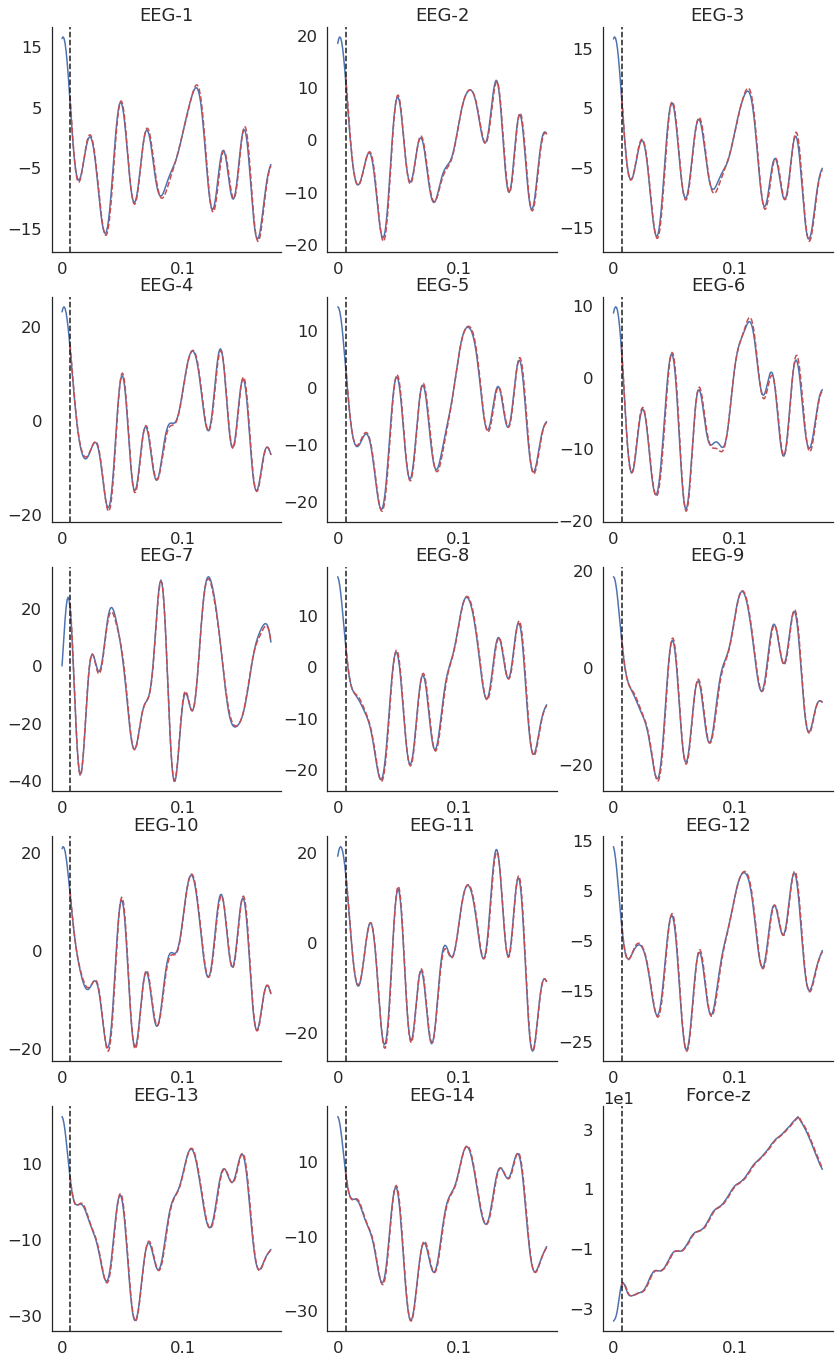

In [16]:
# Plot the predictions in time domain given thresholded DWT coeffs 
# for different combinations of eeg+emg+force:

results_for_eeg = 0
results_for_eegemg = 3
results_for_eegforce = 4
results_for_all = -1

sns.set(style="white", palette="muted", color_codes=True, font_scale=1.5)
# Set up the matplotlib figure (all forecasts subplot figure)
f, axes = plt.subplots(5, 3, figsize=(14, 24), sharex=False, sharey=False)
sns.despine()

T = math.floor(10*(nPreds+P)/fs) + 1

if T != 1:
    z = [decimal.Decimal(i) / decimal.Decimal(10) for i in range(0, T)]
else:
    T = math.floor(100*(nPreds+P)/fs) + 1
    z = [decimal.Decimal(i) / decimal.Decimal(100) for i in range(0, T, 2)]

    
plt.setp(axes, xticks=z, xticklabels=z)

# 2 subtracted because of the extra wavelet coeff. in the second resolution level
x_gt = np.arange(0, (nPreds+P)/fs, 1/fs) 
x_pred = np.arange(P/fs, (nPreds+P)/fs, 1/fs)

for j in range(1,15,1):
    sns.set()
    axes[math.floor((j-1)/3),(j-1)%3].plot(x_gt, test_data[patient_id][trial_id].iloc[:nPreds+P,j-1].values, 
                                           color='b', label="True")
    axes[math.floor((j-1)/3), (j-1)%3].plot(x_pred, 
                                            s_list[modality][patient_id][trial_id].iloc[:nPreds,j-1].values, 
                                            color='r', linestyle='--', label="Prediction")
    axes[math.floor((j-1)/3), (j-1)%3].axvline(x=P/fs, linestyle='--', color='k')
    axes[math.floor((j-1)/3), (j-1)%3].title.set_text("EEG-%i" %j)
    axes[math.floor((j-1)/3), (j-1)%3].set_yticks(axes[math.floor((j-1)/3), (j-1)%3].get_yticks()[1:-1:2])
    #axes[0, 0].legend(frameon=False)
    #plt.setp(axes[0, 0].get_legend().get_texts(), fontsize='14')

if modality in [results_for_all, results_for_eegforce]: #force predictions exist
    axes[4,2].plot(x_gt, test_data[patient_id][trial_id].iloc[:nPreds+P, -1].values, 
                   color='b', label="True")
    axes[4,2].plot(x_pred, s_list[modality][patient_id][trial_id].iloc[:nPreds, -1].values, 
                   color='r', linestyle='--', label="Prediction")
    axes[4,2].axvline(x=P/fs, linestyle='--', color='k')
    axes[4,2].ticklabel_format(axis='y', style='sci', scilimits=(4,-4))
    axes[4,2].title.set_text("Force-z")
    axes[4,2].set_yticks(axes[4, 2].get_yticks()[1:-1:2])
    #axes[4,2].legend() 

plt.savefig("VARResults/predictions_temporal.pdf", bbox_inches="tight")

### Displaying Goodness of Fit Performance for Different Input Combinations (Skip to the next section to use pickled data)

In [20]:
'''
Return the mean absolute percentage error between the true signal and prediction
https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
'''
def find_mape(true, pred):
    return 100 * np.mean(np.abs((true-pred)/true))

eeg_ind = list(range(0,14,1))

# evaluate and save the rmse for each patient:
for participant_id in tqdm_notebook(range(num_participants), ascii=True):

    ###### RMSE for only EEG prediction ######
    eeg_errs = []
    for i, test_trial in enumerate(test_data[participant_id]):
        sum_eeg_err = 0
        for j in eeg_ind:
            # i, which is 1 sample for each trial,
            # because the reconstructed signal is 1 sample longer than the original
            sum_eeg_err += np.sqrt(mse(test_trial.iloc[P:nPreds+P, j].values, 
                                   s_list[0][participant_id][i].iloc[:nPreds, j].values))
        eeg_errs.append(sum_eeg_err / num_eeg_ch)

    # Save the RMSE as a dataframe:
    err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs)})
    err_df.to_pickle("VARResults/err_bars_forEEGOnly_temporal_id%i.pkl" %(participant_id+1))


    ###### RMSE for only FORCE prediction ######
    force_errs = []
    for i, test_trial in enumerate(test_data[participant_id]):
        force_errs.append(np.sqrt(mse(test_trial.iloc[P:nPreds+P, -1].values, 
                                      s_list[2][participant_id][i].iloc[:nPreds, -1].values)))

    # Save the RMSE as a dataframe:
    err_df = pd.DataFrame({'force': np.asarray(force_errs)})
    err_df.to_pickle("VARResults/err_bars_forForceOnly_temporal_id%i.pkl" %(participant_id+1))


    ###### RMSE for EEG and FORCE prediction ######
    eeg_errs, force_errs = [], []
    for i, test_trial in enumerate(test_data[participant_id]):
        sum_eeg_err = 0
        for j in eeg_ind:
            # i, which is 1 sample for each trial,
            # because the reconstructed signal is 1 sample longer than the original
            sum_eeg_err += np.sqrt(mse(test_trial.iloc[P:nPreds+P, j].values, 
                                       s_list[4][participant_id][i].iloc[:nPreds, j].values))
        eeg_errs.append(sum_eeg_err / num_eeg_ch)   
        force_errs.append(np.sqrt(mse(test_trial.iloc[P:nPreds+P, -1].values, 
                                      s_list[4][participant_id][i].iloc[:nPreds, -1].values))) 

    # Save the RMSE as a dataframe:
    err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs),
                           'force': np.asarray(force_errs)})
    err_df.to_pickle("VARResults/err_bars_forEEGandForce_temporal_id%i.pkl" %(participant_id+1))


    ###### RMSE for EMG and FORCE prediction ######
    force_errs = []
    for i, test_trial in enumerate(test_data[participant_id]):
        force_errs.append(np.sqrt(mse(test_trial.iloc[P:nPreds+P, -1].values, 
                                      s_list[5][participant_id][i].iloc[:nPreds, -1].values))) 

    # Save the RMSE as a dataframe:
    err_df = pd.DataFrame({'force': np.asarray(force_errs)})
    err_df.to_pickle("VARResults/err_bars_forEMGandForce_temporal_id%i.pkl" %(participant_id+1))


    # RMSE for EEG and EMG prediction
    eeg_errs = []
    for i, test_trial in enumerate(test_data[participant_id]):
        sum_eeg_err = 0
        for j in eeg_ind:
            sum_eeg_err += np.sqrt(mse(test_trial.iloc[P:nPreds+P, j].values, 
                                       s_list[3][participant_id][i].iloc[:nPreds, j].values))
        eeg_errs.append(sum_eeg_err / num_eeg_ch)

    # Save the RMSE as a dataframe:
    err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs)})
    err_df.to_pickle("VARResults/err_bars_forEEGandEMG_temporal_id%i.pkl" %(participant_id+1))


    # RMSE for ALL modalities (EEG, EMG and FORCE prediction)
    eeg_errs, force_errs = [], []
    for i, test_trial in enumerate(test_data[participant_id]):
        sum_eeg_err = 0
        for j in eeg_ind:
            # i, which is 1 sample for each trial,
            # because the reconstructed signal is 1 sample longer than the original
            sum_eeg_err += np.sqrt(mse(test_trial.iloc[P:nPreds+P, j].values, 
                                       s_list[-1][participant_id][i].iloc[:nPreds, j].values))
        eeg_errs.append(sum_eeg_err / num_eeg_ch)   
        force_errs.append(np.sqrt(mse(test_trial.iloc[P:nPreds+P, -1].values, 
                                      s_list[-1][participant_id][i].iloc[:nPreds, -1].values)))

    # Save the RMSE as a dataframe:
    err_df = pd.DataFrame({'eeg': np.asarray(eeg_errs),
                           'force': np.asarray(force_errs)})
    err_df.to_pickle("VARResults/err_bars_forAll_temporal_id%i.pkl" %(participant_id+1))

### Pre-computed Error Data 

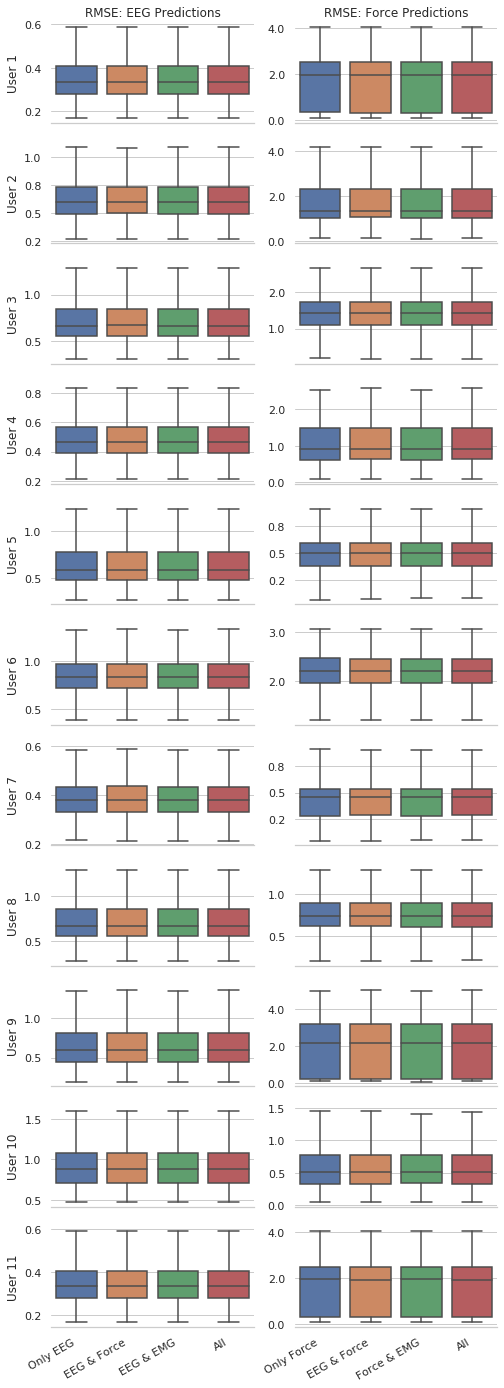

In [43]:
onlyEEG_errs = []
onlyForce_errs = []
EEGandForce_errs = []
EMGandForce_errs = []
EEGandEMG_errs = []
all_errs = []
force_box_plot = []
eeg_box_plot = []

for i in range(num_participants):
    onlyEEG_errs.append(pd.read_pickle("VARResults/err_bars_forEEGOnly_temporal_id%i.pkl" %(i+1)))
    onlyForce_errs.append(pd.read_pickle("VARResults/err_bars_forForceOnly_temporal_id%i.pkl" %(i+1)))
    EEGandForce_errs.append(pd.read_pickle("VARResults/err_bars_forEEGandForce_temporal_id%i.pkl" %(i+1)))
    EMGandForce_errs.append(pd.read_pickle("VARResults/err_bars_forEMGandForce_temporal_id%i.pkl" %(i+1)))
    EEGandEMG_errs.append(pd.read_pickle("VARResults/err_bars_forEEGandEMG_temporal_id%i.pkl" %(i+1)))
    all_errs.append(pd.read_pickle("VARResults/err_bars_forAll_temporal_id%i.pkl" %(i+1)))
       
    force_box_plot.append(pd.DataFrame({'Only Force': onlyForce_errs[-1]['force'].values, 
                                        'EEG & Force': EEGandForce_errs[-1]['force'].values, 
                                        'Force & EMG': EMGandForce_errs[-1]['force'].values, 
                                        'All': all_errs[-1]['force'].values}))
    eeg_box_plot.append(pd.DataFrame({'Only EEG': onlyEEG_errs[-1]['eeg'].values,
                                      'EEG & Force': EEGandForce_errs[-1]['eeg'].values,
                                      'EEG & EMG': EEGandEMG_errs[-1]['eeg'].values,
                                      'All': all_errs[-1]['eeg'].values}))

sns.set(style="whitegrid", font_scale=1)
# Set up the matplotlib figure
f, axes = plt.subplots(num_participants, 2, figsize=(8, 24), sharex=False)
sns.despine(left=True)

sns.boxplot(data=eeg_box_plot[i], showfliers=False, ax=axes[0,0]).set_title('RMSE: EEG Predictions')
sns.boxplot(data=force_box_plot[i], showfliers=False, ax=axes[0,1]).set_title('RMSE: Force Predictions')
axes[0,0].set_ylabel('User %s' %str(1))

for i in range(1, num_participants):
    sns.boxplot(data=eeg_box_plot[i], showfliers=False, ax=axes[i,0])
    sns.boxplot(data=force_box_plot[i], showfliers=False, ax=axes[i,1])
    axes[i,0].set_ylabel('User %s' %str(i+1))

for idx, ax in enumerate(axes.flatten()):
    if idx < 2*(num_participants-1): ax.set_xticklabels([])
    else: ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")  
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

path = "VARResults/error_boxes_temporal pdf"
plt.savefig(path, bbox_inches="tight")

# Wilcoxon Rank-Sum Test

In [44]:
onlyEEG_errs = []
onlyForce_errs = []
EEGandForce_errs = []
EMGandForce_errs = []
EEGandEMG_errs = []
all_errs = []
force_box_plot = []
eeg_box_plot = []

keys = ["eeg_eegforce", "eeg_eegemg", "force_eegforce", "force_emgforce", 
        "eegforce_all", "eegemg_all", "eegforce_all", "emgforce_all"]
rows = ['P%i' %(i+1) for i in range(num_participants)]
wilcox_df = pd.DataFrame(index=rows, columns=keys)

for i in range(num_participants):
    onlyEEG_errs.append(pd.read_pickle("VARResults/err_bars_forEEGOnly_temporal_id%i.pkl" %(i+1)))
    onlyForce_errs.append(pd.read_pickle("VARResults/err_bars_forForceOnly_temporal_id%i.pkl" %(i+1)))
    EEGandForce_errs.append(pd.read_pickle("VARResults/err_bars_forEEGandForce_temporal_id%i.pkl" %(i+1)))
    EMGandForce_errs.append(pd.read_pickle("VARResults/err_bars_forEMGandForce_temporal_id%i.pkl" %(i+1)))
    EEGandEMG_errs.append(pd.read_pickle("VARResults/err_bars_forEEGandEMG_temporal_id%i.pkl" %(i+1)))
    all_errs.append(pd.read_pickle("VARResults/err_bars_forAll_temporal_id%i.pkl" %(i+1)))   
    
    wilcox_df.loc[rows[i],"eeg_eegforce"] = ranksums(onlyEEG_errs[-1].values.reshape(-1,), 
                                                     EEGandForce_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"eeg_eegemg"] = ranksums(onlyEEG_errs[-1].values.reshape(-1,),
                                                   EEGandEMG_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"force_eegforce"] = ranksums(onlyForce_errs[-1].values.reshape(-1,), 
                                                       EEGandForce_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"force_emgforce"] = ranksums(onlyForce_errs[-1].values.reshape(-1,), 
                                                       EMGandForce_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"eegforce_all"] = ranksums(EEGandForce_errs[-1].values.reshape(-1,), 
                                                     all_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"eegemg_all"] = ranksums(EEGandEMG_errs[-1].values.reshape(-1,), 
                                                   all_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"eegforce_all"] = ranksums(EEGandForce_errs[-1].values.reshape(-1,), 
                                                     all_errs[-1].values.reshape(-1,))[1]/2
    wilcox_df.loc[rows[i],"emgforce_all"] = ranksums(EMGandForce_errs[-1].values.reshape(-1,), 
                                                     all_errs[-1].values.reshape(-1,))[1]/2
wilcox_df

,eeg_eegforce,eeg_eegemg,force_eegforce,force_emgforce,eegforce_all,eegemg_all,eegforce_all,emgforce_all
P1,1.64252e-60,0.49887,4.94366e-61,0.481855,0.493608,1.55103e-60,0.493608,4.70082e-61
P2,4.24875e-105,0.49841,4.08271e-105,0.491253,0.49296,5.89561e-105,0.49296,5.5309e-105
P3,4.48725e-64,0.495497,6.93733e-64,0.472417,0.489453,3.68111e-64,0.489453,5.7789e-64
P4,3.57663e-37,0.484171,1.88452e-34,0.476113,0.486795,3.75021e-37,0.486795,1.94841e-34
P5,2.64964e-16,0.497829,2.73021e-17,0.491458,0.490085,1.89771e-16,0.490085,2.03462e-17
P6,9.13462e-70,0.49952,5.07707e-70,0.483971,0.4938,9.03692e-70,0.4938,4.82564e-70
P7,1.05896e-05,0.498416,4.28503e-05,0.47371,0.484578,1.21984e-05,0.484578,5.09494e-05
P8,0.0308102,0.494577,0.0357867,0.442206,0.457355,0.0364622,0.457355,0.0423364
P9,0.00772413,0.49016,0.022464,0.363903,0.43833,0.00726435,0.43833,0.0217744
P10,1.17695e-14,0.49215,1.13172e-14,0.465153,0.496761,1.07055e-14,0.496761,1.13542e-14
